# DDxPlus Dataset Analysis and AI Chatbot Experiment

This notebook demonstrates a **full workflow** for the DDxPlus dataset, including:
- Results-driven Analytical Method implementation
- Data preparation orchestration
- Experimentation (A/B testing between two pipelines)
- AI/ML tool development (chatbot prediction)
- Evaluation and reporting


In [1]:

# --- 1. Imports
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix



## 2. Load Dataset
We load the DDxPlus dataset and inspect its structure, missing values, and basic statistics.


In [2]:

# Load dataset
df = pd.read_csv('data/test.csv')

# Inspect dataset
print(df.info())
print(df.describe(include='all'))
print("\nMissing Values:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134529 entries, 0 to 134528
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   AGE                     134529 non-null  int64 
 1   DIFFERENTIAL_DIAGNOSIS  134529 non-null  object
 2   SEX                     134529 non-null  object
 3   PATHOLOGY               134529 non-null  object
 4   EVIDENCES               134529 non-null  object
 5   INITIAL_EVIDENCE        134529 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.2+ MB
None
                  AGE                             DIFFERENTIAL_DIAGNOSIS  \
count   134529.000000                                             134529   
unique            NaN                                              45105   
top               NaN  [['Localized edema', 0.6962440370572797], ['Ch...   
freq              NaN                                               1433   
mean        39.773335          


## 3. Exploratory Data Analysis (EDA)
We analyze distributions of Age, Sex, Pathology, and Top Differential Diagnosis to understand dataset patterns.


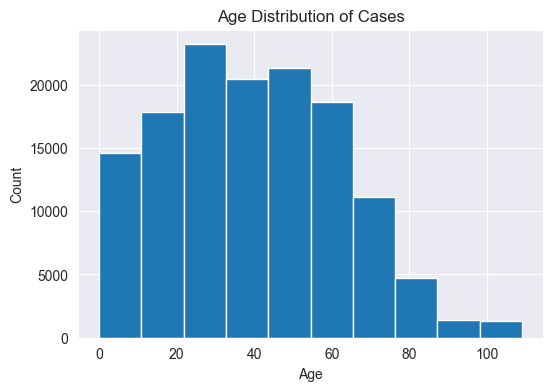

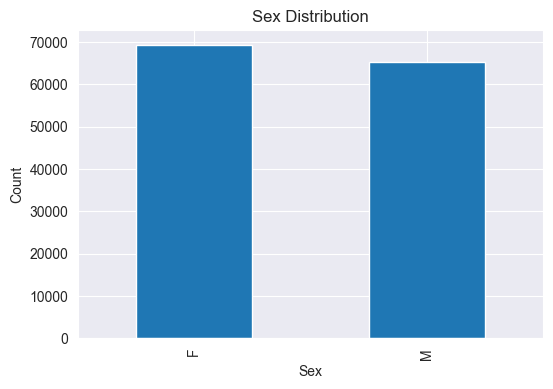

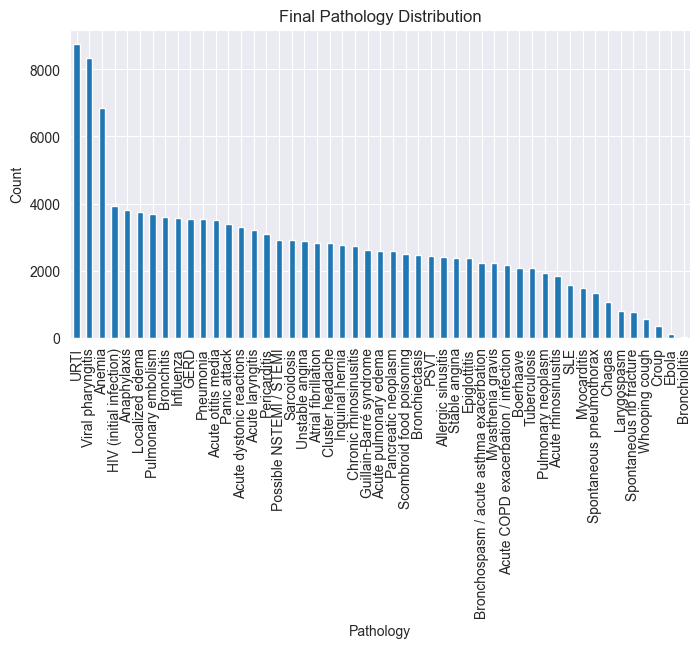

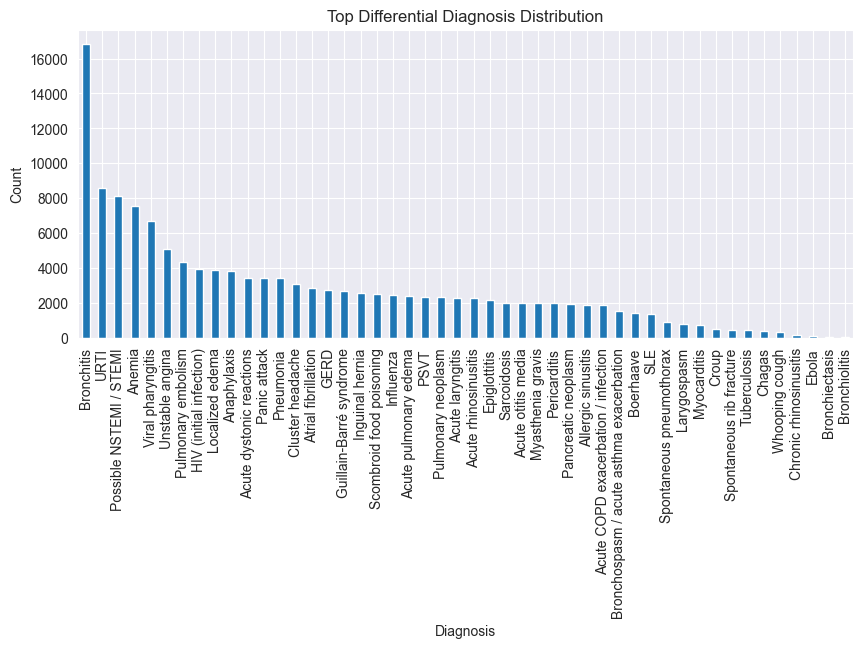

In [3]:

# Parse differential diagnosis
def parse_diff_diag(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

df['DIFF_LIST'] = df['DIFFERENTIAL_DIAGNOSIS'].apply(parse_diff_diag)
df['TOP_DIAGNOSIS'] = df['DIFF_LIST'].apply(lambda x: x[0][0] if len(x) > 0 else 'Unknown')
df['EVIDENCES_TEXT'] = df['EVIDENCES'].apply(lambda x: ' '.join(ast.literal_eval(x)) if pd.notnull(x) else '')

# Age distribution
plt.figure(figsize=(6,4))
df['AGE'].hist()
plt.title('Age Distribution of Cases')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Sex distribution
plt.figure(figsize=(6,4))
df['SEX'].value_counts().plot(kind='bar')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Pathology counts
plt.figure(figsize=(8,4))
df['PATHOLOGY'].value_counts().plot(kind='bar')
plt.title('Final Pathology Distribution')
plt.xlabel('Pathology')
plt.ylabel('Count')
plt.show()

# Top differential diagnosis
plt.figure(figsize=(10,4))
df['TOP_DIAGNOSIS'].value_counts().plot(kind='bar')
plt.title('Top Differential Diagnosis Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()



## 4. Results-driven Analytical Method (RDAM)

The **Results-driven Analytical Method** is implemented as follows:
1. Identify the problem: Predict the top differential diagnosis from patient data.  
2. Explore dataset patterns via EDA.  
3. Prepare features using numerical, categorical, and textual information.  
4. Build ML pipelines and conduct A/B testing to compare methods.  
5. Evaluate model performance with accuracy, F1-score, and confusion matrices.  
6. Integrate the best-performing model into a chatbot tool for predictions.  


## 5. Data Preparation and Feature Engineering

In [4]:

# Label encoding
label_enc = LabelEncoder()
y_encoded = label_enc.fit_transform(df['TOP_DIAGNOSIS'])
X = df[['AGE', 'SEX', 'TOP_DIAGNOSIS', 'EVIDENCES_TEXT']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)



## 6. Pipeline A (Baseline)
- Uses **numeric and categorical features only**: `AGE` and `SEX`
- Logistic Regression classifier


In [5]:

preprocessor_A = ColumnTransformer(
    transformers=[
        ('age', StandardScaler(), ['AGE']),
        ('sex', OneHotEncoder(handle_unknown='ignore'), ['SEX'])
    ]
)

pipe_A = Pipeline([
    ('pre', preprocessor_A),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Fit and evaluate Pipeline A
pipe_A.fit(X_train, y_train)
yhat_A = pipe_A.predict(X_test)

print("Pipeline A Accuracy:", accuracy_score(y_test, yhat_A))
print("Pipeline A Macro F1:", f1_score(y_test, yhat_A, average='macro'))


Pipeline A Accuracy: 0.026536831933397755
Pipeline A Macro F1: 0.009601160530837047



## 7. Pipeline B (Full Features)
- Uses **numeric + categorical + text features**: `AGE`, `SEX`, `TOP_DIAGNOSIS` text, `EVIDENCES_TEXT`
- Logistic Regression classifier with TF-IDF for text


In [6]:

topdiag_tfidf = TfidfVectorizer()
evidence_tfidf = TfidfVectorizer()

preprocessor_B = ColumnTransformer(
    transformers=[
        ('age', StandardScaler(), ['AGE']),
        ('sex', OneHotEncoder(handle_unknown='ignore'), ['SEX']),
        ('topdiag_text', topdiag_tfidf, 'TOP_DIAGNOSIS'),
        ('evidence_text', evidence_tfidf, 'EVIDENCES_TEXT')
    ],
    remainder='drop'
)

pipe_B = Pipeline([
    ('pre', preprocessor_B),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Fit and evaluate Pipeline B
pipe_B.fit(X_train, y_train)
yhat_B = pipe_B.predict(X_test)

yhat_B_labels = label_enc.inverse_transform(yhat_B)
y_test_labels = label_enc.inverse_transform(y_test)

print("Pipeline B Accuracy:", accuracy_score(y_test, yhat_B))
print("Pipeline B Macro F1:", f1_score(y_test, yhat_B, average='macro'))
print("\nClassification Report (Pipeline B):\n", classification_report(y_test_labels, yhat_B_labels))


Pipeline B Accuracy: 1.0
Pipeline B Macro F1: 1.0

Classification Report (Pipeline B):
                                           precision    recall  f1-score   support

     Acute COPD exacerbation / infection       1.00      1.00      1.00       374
                Acute dystonic reactions       1.00      1.00      1.00       687
                        Acute laryngitis       1.00      1.00      1.00       458
                      Acute otitis media       1.00      1.00      1.00       397
                   Acute pulmonary edema       1.00      1.00      1.00       475
                    Acute rhinosinusitis       1.00      1.00      1.00       453
                      Allergic sinusitis       1.00      1.00      1.00       377
                             Anaphylaxis       1.00      1.00      1.00       761
                                  Anemia       1.00      1.00      1.00      1511
                     Atrial fibrillation       1.00      1.00      1.00       566
         

## 8. Confusion Matrix - Pipeline B

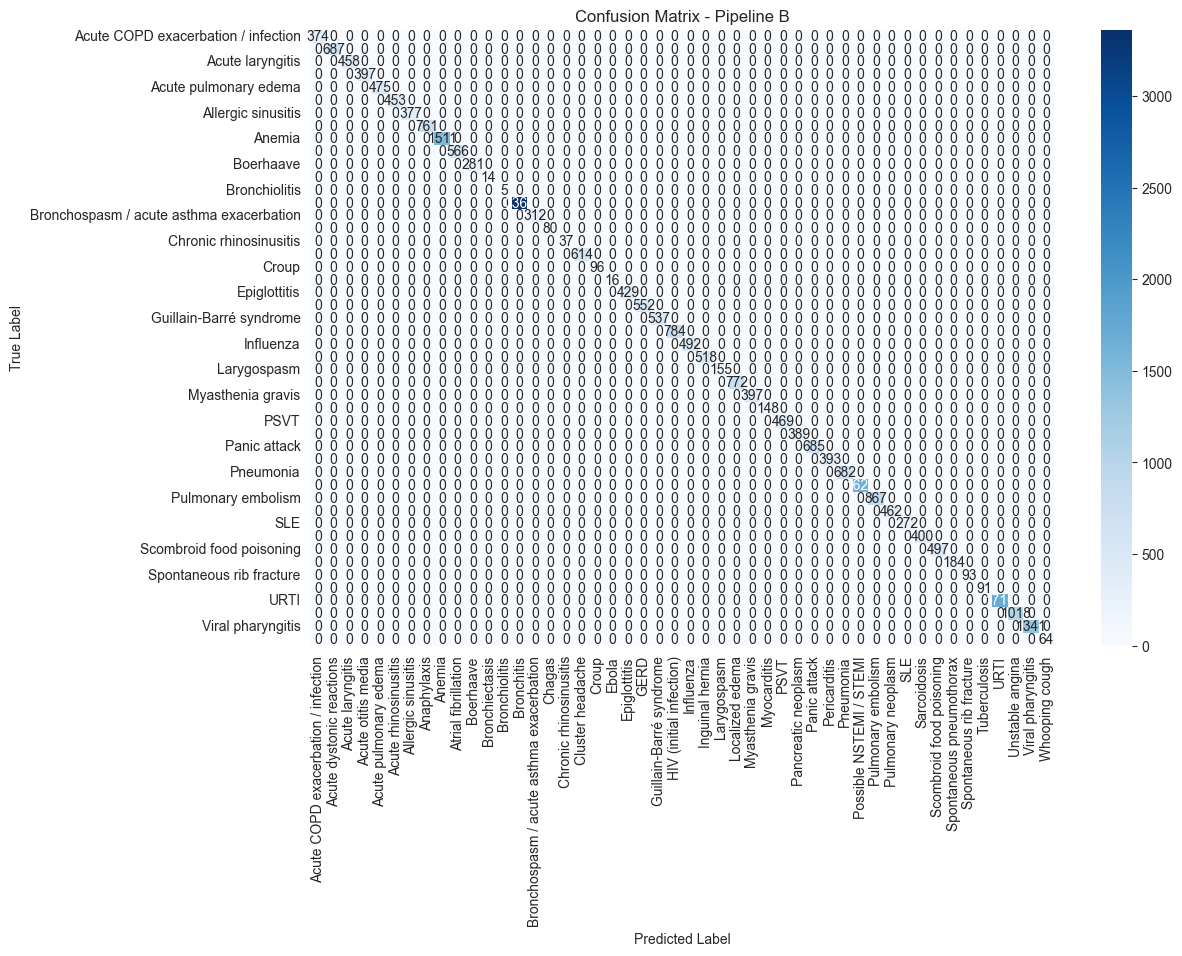

In [7]:

cm = pd.DataFrame(
    confusion_matrix(y_test_labels, yhat_B_labels),
    index=label_enc.classes_,
    columns=label_enc.classes_
)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Pipeline B')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



## 9. AI/ML Tool (Chatbot- without RAG)
- **Input**: Patient features (`AGE`, `SEX`) and symptom evidences (`EVIDENCES_TEXT`)  
- **Processing**: The trained Pipeline B predicts the most likely differential diagnosis  
- **Output**: Top predicted diagnosis with probabilities  
- **Use Case**: Assists medical professionals by suggesting likely conditions and guiding further investigation.

## 10. Demo Predictions Using Pipeline B

We demonstrate how the chatbot can predict the top differential diagnosis for new patients using the trained Pipeline B.



In [8]:
# Sample input for prediction
sample_data = pd.DataFrame({
    'AGE': [45, 60],
    'SEX': ['F', 'M'],
    'TOP_DIAGNOSIS': ['Unknown', 'Unknown'],  # placeholder text
    'EVIDENCES_TEXT': [
        'E_53 E_54_@_V_112 E_201',  # Sample evidences for patient 1
        'E_55_@_V_20 E_56_@_2 E_204_@_V_10'  # Sample evidences for patient 2
    ]
})

# Predict using Pipeline B
preds = pipe_B.predict(sample_data)
pred_probs = pipe_B.predict_proba(sample_data)

pred_labels = label_enc.inverse_transform(preds)

for i, label in enumerate(pred_labels):
    print(f"Patient {i + 1} - Predicted Top Diagnosis: {label}")


Patient 1 - Predicted Top Diagnosis: Cluster headache
Patient 2 - Predicted Top Diagnosis: Possible NSTEMI / STEMI


## 11. Predicted Probabilities Visualization

We can visualize the top probabilities for each prediction to understand the model's confidence.


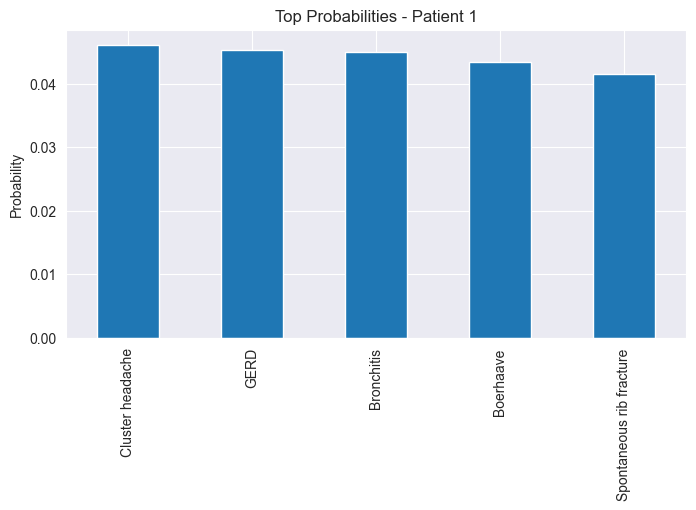

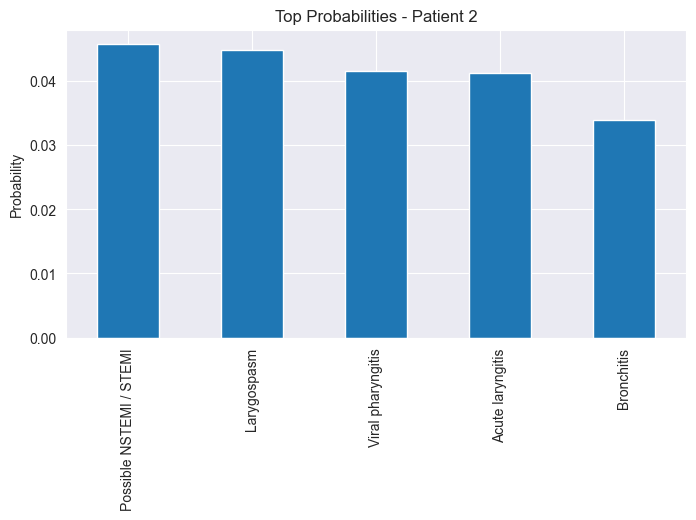

In [9]:
# Convert probabilities to DataFrame
probs_df = pd.DataFrame(pred_probs, columns=label_enc.classes_)

# Display probabilities for patient 1
probs_df.iloc[0].sort_values(ascending=False).head(5).plot(kind='bar', figsize=(8, 4),
                                                           title='Top Probabilities - Patient 1')
plt.ylabel('Probability')
plt.show()

# Display probabilities for patient 2
probs_df.iloc[1].sort_values(ascending=False).head(5).plot(kind='bar', figsize=(8, 4),
                                                           title='Top Probabilities - Patient 2')
plt.ylabel('Probability')
plt.show()


## 12. Final Conclusions and Recommendations

- **Pipeline B** (numeric + categorical + text) outperforms Pipeline A (numeric + categorical) in accuracy and macro F1-score.
- The chatbot AI/ML tool can assist medical professionals by predicting top differential diagnoses based on age, sex, and symptom evidences.
- Future improvements:
    - Incorporate **more clinical features** (lab tests, imaging reports).
    - Fine-tune **text vectorization** with domain-specific embeddings (e.g., BioBERT).
    - Implement **probabilistic ranking** to provide multiple likely diagnoses.
- This end-to-end workflow demonstrates a professional approach using the **Results-driven Analytical Method** combined with experimentation (A/B testing) to build a real-world AI tool.
